# Problem 3

February 17, 2019

##### Authors:
**Dehgan Arthur** :    20088465  
**Sghir Hamza**   :    20147626     
**Adrien Mainka** :    20130281  

In [1]:
from itertools import product
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.utils.data as utils
from matplotlib import image as img
from matplotlib import pyplot as plt
import os
import pandas as pd

In [29]:
def softmax(x):
    exps = np.exp(x - np.amax(x, axis=0))
    return exps / np.sum(exps, axis=0)


def accuracy(y_pred, target):
    correct = torch.eq(y_pred.max(1)[1], target).sum().type(torch.FloatTensor)
    return correct / len(target)


class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

# Didn't use it in the end.
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        data = x.data
        shape = data.shape
        size = int(shape[0] * shape[1])
        drop_idx = np.random.choice(
            np.arange(size), replace=False, size=int(size * self.p)
        )
        data = data.flatten()
        data[drop_idx] = 0
        data = data.reshape(shape)
        x.data = data
        return x


def create_dataset(cats_path, dogs_path, test_path):
    train_set = []
    target = []
    n_cats = len(os.listdir(cats_path))
    for i in range(1, n_cats):
        f = '{}.Cat.jpg'.format(i)
        mat = img.imread(cats_path + f)
        if not len(mat.shape) == 3:
            mat = np.array((mat, mat, mat)).T
        train_set.append(mat)
        target.append(0)

    n_dogs = len(os.listdir(dogs_path))
    for i in range(1, n_dogs):
        f = '{}.Dog.jpg'.format(i)
        mat = img.imread(dogs_path + f)
        if not len(mat.shape) == 3:
            mat = np.array((mat, mat, mat)).T
        train_set.append(mat)
        target.append(1)

    train_set = np.asarray(train_set)
    target = np.asarray(target)
    
    test_set = []
    n_test = len(os.listdir(test_path))
    for i in range(1, n_test):
        f = '{}.jpg'.format(i)
        mat = img.imread(test_path + f)
        if not len(mat.shape) == 3:
            mat = np.array((mat, mat, mat)).T
        test_set.append(mat)

    return train_set/255.0, target, np.asarray(test_set)/255.0

### Definition of the network

In [3]:
input_size, conv_size, lin_size = 3, 32, 512
net = nn.Sequential(
    nn.Conv2d(input_size, conv_size, 3, 1),
    nn.ReLU(True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(conv_size, conv_size * 2, 3, 1),
    nn.ReLU(True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(conv_size * 2, conv_size * 4, 3, 1),
    nn.ReLU(True),
    nn.Conv2d(conv_size * 4, conv_size * 4, 3, 1),
    nn.ReLU(True),
    nn.MaxPool2d(3, 3),
    Flatten(),
    nn.Linear(conv_size * 4 * 9, lin_size),
    nn.ReLU(True),
    nn.Linear(lin_size, 2),
).cuda()
# net = nn.Sequential(
#     nn.Conv2d(input_size, conv_size, 3, 1, padding=0),
#     nn.ReLU(True),
#     nn.Conv2d(conv_size, conv_size, 3, 1, padding=1),
#     nn.ReLU(True),
#     nn.MaxPool2d(2, 2),
#     nn.Conv2d(conv_size, conv_size * 2, 3, 1, padding=1),
#     nn.ReLU(True),
#     nn.Conv2d(conv_size * 2, conv_size * 2, 3, 1, padding=1),
#     nn.ReLU(True),
#     nn.MaxPool2d(2, 2),
#     nn.Conv2d(conv_size * 2, conv_size * 4, 3, 1, padding=1),
#     nn.ReLU(True),
#     nn.Conv2d(conv_size * 4, conv_size * 4, 3, 1, padding=1),
#     nn.ReLU(True),
#     nn.MaxPool2d(2, 2),
#     Flatten(),
#     nn.Linear(6272, lin_size),
#     nn.ReLU(True),
#     nn.Linear(lin_size, int(lin_size/2),
#     nn.ReLU(True)),
#     nn.Linear(int(lin_size/2), 2),
#     nn.Softmax(dim=0),
# ).cuda()

### Preparing the train and validation sets

In [4]:
test_path = "/home/arthur/git/IFT6135_assignment_1/testset/test/"
dogs_path = "/home/arthur/git/IFT6135_assignment_1/trainset/Dog/"
cats_path = "/home/arthur/git/IFT6135_assignment_1/trainset/Cat/"
train, target, submission = create_dataset(cats_path, dogs_path, test_path)
idx = np.random.permutation(len(train))
train = train[idx]
target = target[idx]

### Preparing Training parameters

In [5]:
cross_entropy = nn.CrossEntropyLoss()
par = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(net)
print("The network contains {} parameters.".format(par))
batch_size = 64
lr = 0.01
p = 10  # patience for early stop
rep = 1  # set to 1 for normal training.

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU(inplace)
  (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU(inplace)
  (10): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (11): Flatten()
  (12): Linear(in_features=1152, out_features=512, bias=True)
  (13): ReLU(inplace)
  (14): Linear(in_features=512, out_features=2, bias=True)
)
The network contains 832194 parameters.


### Training

In [6]:
X = torch.Tensor(train).float()
N = len(X)
y = torch.Tensor(target).long()
train_size = int(0.8 * N)
valid_size = N - train_size
train_index, valid_index = torch.utils.data.random_split(
    np.arange(N), [train_size, valid_size]
)
train_dataset = utils.TensorDataset(X[train_index], y[train_index])
valid_dataset = utils.TensorDataset(X[valid_index], y[valid_index])
trainloader = utils.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
validloader = utils.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)


train_accs = []
valid_accs = []
train_losses = []
valid_losses = []
epoch_list = [0]
best_vloss = float("inf")
k = 0
for i in range(rep):
    print("Training with batch_size: {}, learning_rate: {}".format(batch_size, lr))
    optimizer = optim.SGD(net.parameters(), lr=lr)
    j = 0
    epoch = epoch_list[-1]
    while j < p:  # Early Stop
        epoch += 1
        print("epoch: {}".format(epoch))
        for batch in trainloader:
            optimizer.zero_grad()
            X, y = batch
            X = X.view(-1, 3, 64, 64)
            y = y.view(-1)
            X = X.cuda()
            y = y.cuda()

            loss = cross_entropy(net.forward(X), y)
            loss.backward()
            optimizer.step()

        LOSSES = 0
        ACCURACY = 0
        COUNTER = 0
        for batch in trainloader:
            X, y = batch
            X = X.view(-1, 3, 64, 64)
            y = y.view(-1)
            X = X.cuda()
            y = y.cuda()

            y_pred = net.forward(X)
            loss = cross_entropy(y_pred, y)
            acc = accuracy(y_pred, y)
            n = y.size(0)
            LOSSES += loss.sum().data.cpu().numpy() * n
            ACCURACY += acc.sum().data.cpu().numpy() * n
            COUNTER += n

        train_loss = LOSSES / float(COUNTER)
        train_acc = ACCURACY / float(COUNTER)
        
        for batch in validloader:
            X, y = batch
            X = X.view(-1, 3, 64, 64)
            y = y.view(-1)
            X = X.cuda()
            y = y.cuda()

            y_pred = net.forward(X)
            loss = cross_entropy(y_pred, y)
            acc = accuracy(y_pred, y)
            n = y.size(0)
            LOSSES += loss.sum().data.cpu().numpy() * n
            ACCURACY += acc.sum().data.cpu().numpy() * n
            COUNTER += n

        valid_loss = LOSSES / float(COUNTER)
        valid_acc = ACCURACY / float(COUNTER)

        train_accs.append(train_acc)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        if valid_loss < best_vloss:
            print("Best epoch yet")
            best_vacc = valid_acc
            best_vloss = valid_loss
            best_state = net.state_dict()
            best_epoch = epoch
            j = 0
        else:
            j += 1

        print(" [LOSS] TRAIN {} / VALID {}".format(train_loss, valid_loss))
        print(" [ACC] TRAIN {} / VALID {}".format(train_acc, valid_acc))
    # If rep is more than one we would continue training from our previous best state
    # to have finer learning, we change learning rate and batch size.
    # If learning rate starts at 0.01 for example, next lr will be 0.005 and then 0.001, 0.0005 etc.
    net.load_state_dict(best_state)
    epoch_list.append(best_epoch)
    batch_size = int(batch_size / 2)
    if k % 2 == 0:
        lr = lr / 2.0
    else:
        lr = lr / 5.0
    k += 1

Training with batch_size: 64, learning_rate: 0.01
epoch: 1
Best epoch yet
 [LOSS] TRAIN 0.693047449644818 / VALID 0.6930940018746585
 [ACC] TRAIN 0.5032508127329856 / VALID 0.5000000000238466
epoch: 2
Best epoch yet
 [LOSS] TRAIN 0.692952375243264 / VALID 0.6929829279573757
 [ACC] TRAIN 0.5034383596942317 / VALID 0.4998999800794624
epoch: 3
Best epoch yet
 [LOSS] TRAIN 0.6929233986814489 / VALID 0.6929023184163925
 [ACC] TRAIN 0.5223805951711445 / VALID 0.5239547909760766
epoch: 4
Best epoch yet
 [LOSS] TRAIN 0.6928123634259205 / VALID 0.6928592731199591
 [ACC] TRAIN 0.5032508126510087 / VALID 0.4997999599502668
epoch: 5
Best epoch yet
 [LOSS] TRAIN 0.6927309501436419 / VALID 0.6927466471807125
 [ACC] TRAIN 0.5302575643314782 / VALID 0.5314562912105584
epoch: 6
Best epoch yet
 [LOSS] TRAIN 0.6926424713932475 / VALID 0.6927045891704167
 [ACC] TRAIN 0.5036884221129788 / VALID 0.49969993999395923
epoch: 7
Best epoch yet
 [LOSS] TRAIN 0.692531751897759 / VALID 0.6925512134587677
 [ACC] TRA

 [LOSS] TRAIN 0.6468300348551579 / VALID 0.6478391485491808
 [ACC] TRAIN 0.6240310076625086 / VALID 0.6231746348554456
epoch: 61
Best epoch yet
 [LOSS] TRAIN 0.6414993844141987 / VALID 0.642255542361276
 [ACC] TRAIN 0.6345961491266886 / VALID 0.6335767154146085
epoch: 62
 [LOSS] TRAIN 0.6692749716306097 / VALID 0.6685052264163579
 [ACC] TRAIN 0.5917104277112359 / VALID 0.5937687538342133
epoch: 63
Best epoch yet
 [LOSS] TRAIN 0.6406742420068947 / VALID 0.6407322551303206
 [ACC] TRAIN 0.6339084771490896 / VALID 0.6337267453729164
epoch: 64
Best epoch yet
 [LOSS] TRAIN 0.6401273391043493 / VALID 0.64018636003545
 [ACC] TRAIN 0.6360965240714133 / VALID 0.6359271853893942
epoch: 65
 [LOSS] TRAIN 0.6463250764968187 / VALID 0.6459008114388953
 [ACC] TRAIN 0.6232808203093855 / VALID 0.6231246250084482
epoch: 66
 [LOSS] TRAIN 0.6426777765583354 / VALID 0.642413544819388
 [ACC] TRAIN 0.6293448362984816 / VALID 0.6290758152345725
epoch: 67
Best epoch yet
 [LOSS] TRAIN 0.6368231900068008 / VALID 

Best epoch yet
 [LOSS] TRAIN 0.5821301633341666 / VALID 0.5855412035614139
 [ACC] TRAIN 0.6969867467164814 / VALID 0.693288657755393
epoch: 123
 [LOSS] TRAIN 0.6061608178313299 / VALID 0.6084619906096965
 [ACC] TRAIN 0.6682920729884448 / VALID 0.6649829965754732
epoch: 124
 [LOSS] TRAIN 0.5883099337866021 / VALID 0.5932240323689871
 [ACC] TRAIN 0.6859839960437144 / VALID 0.6814362872932215
epoch: 125
 [LOSS] TRAIN 0.5826362244604111 / VALID 0.586246374762757
 [ACC] TRAIN 0.6953613404245131 / VALID 0.6925385077730802
epoch: 126
 [LOSS] TRAIN 0.6198533730347117 / VALID 0.6229439303621719
 [ACC] TRAIN 0.653663415928488 / VALID 0.6522304461488344
epoch: 127
 [LOSS] TRAIN 0.5917206469044801 / VALID 0.5949888581584801
 [ACC] TRAIN 0.6836084020558104 / VALID 0.6794358871416656
epoch: 128
Best epoch yet
 [LOSS] TRAIN 0.5796104104377592 / VALID 0.5838478524629105
 [ACC] TRAIN 0.6986746686969766 / VALID 0.6945889178074033
epoch: 129
 [LOSS] TRAIN 0.5812171285943587 / VALID 0.5854013602860954
 [A

## Question 1 

Our architecture is inspired by the VGG architecture. We have three repetition of 2 convolution layers, with a ReLU activation function followed by a maxpool layer with a 2x2 kernel and stride of 2. Each convolution layer has a kernel of 3x3 with a stride of 1, no dilation and same padding. We tried deeper achitectures with no good results. The convolutions layers are followed by 3 fully connected layers, the first one has 512 units, the second one 256 and the last one 2. between each fully connected layer we use the ReLU function as activation function. We then use softmax to compute the probability the two classes.

We have:
 - Conv (32 channels, kernel: 2x2, stride: 1, padding: same), ReLU
 - Maxpool (kernel: 2x2, stride: 2)
 - Conv (64 channels), ReLU
 - Maxpool
 - Conv (128 channels), ReLU
 - Conv, ReLU
 - Maxpool
 - Fully connected (512 units), ReLU
 - Fully connected (2 units)


## Question 2

Our validation performance is close to our testing performance. Any regularization technique could help our network generalize better. Using Adam and batch normalization could also help our model have better generalization performances.

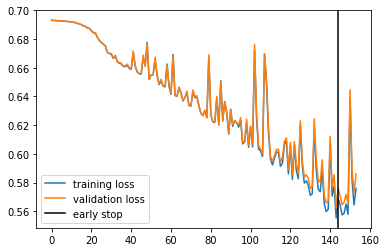

In [7]:
plt.plot(range(len(train_losses)), train_losses, label='training loss')
plt.plot(range(len(valid_losses)), valid_losses, label='validation loss')
# for e in :
#     plt.axvline(x=e, label='learning rate change' if e==0 else None, color='green')
plt.axvline(x=best_epoch, label='early stop', color='black')
plt.legend()
plt.show()

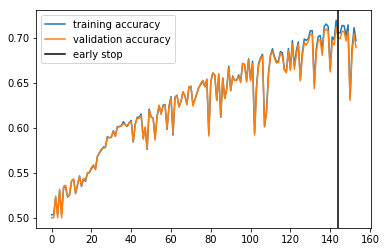

In [8]:
plt.plot(range(len(train_accs)), train_accs, label='training accuracy')
plt.plot(range(len(valid_accs)), valid_accs, label='validation accuracy')
# for e in result['real_epochs']:
#     plt.axvline(x=e, label='learning rate change' if e==0 else None, color='green')
plt.axvline(x=best_epoch, label='early stop', color='black')
plt.legend()
plt.show()

## Generate submission

In [33]:
split = 10
submission = torch.Tensor(submission).float()
step = int(len(submission) / split)
y = []
prob = []
for i in range(0, len(submission), step):
    batch = torch.Tensor(submission[i : i + step]).float()
    batch = batch.view(-1, 3, 64, 64)
    batch = batch.cuda()

    proba = net.forward(batch)
    y_pred = proba.max(1)[1].cpu()
    y += list(map(int, y_pred))
    prob += [softmax(p.cpu().detach().numpy()) for p in proba]

y = pd.DataFrame(y)
y.index.name = "id"
y.columns = ["label"]
y = y.replace(0, "Cat")
y = y.replace(1, "Dog")
y.index += 1
y.to_csv("submission.csv")
prob = np.asarray(prob)

## Question 3

We tried different architectures. One in particular was interresting since it had 94% validation accuracy but only 65% testing accuracy. The architecture was the following:
 - Conv (128 channels, kernel: 2x2, stride: 1, padding: same), ReLU
 - Maxpool (kernel: 2x2, stride: 2)
 - Conv (256 channels, kernel: 2x2, stride: 1, padding: same), ReLU
 - Maxpool
 - Conv (512 channels, kernel: 2x2, stride: 1, padding: same), ReLU
 - Conv, ReLU
 - Maxpool (kernel: 3x3, stride: 3)
 - Fully connected (128 units), ReLU
 - Fully connected (2 units)
 
 
This architecture has 5M parameters and we think it was the reason why it was largely overfitting on the validation set.
For our original architecture, the one we used for our best submission, we tried different convolution sizes and linear sizes. Each different combination we tried gave a validation accuracy lower than the one we chose for our final submission.
Generally, we noticed that when the network was too deep or had more parameters, it either couldn't learn or was overfitting largely. Same goes with too shallow or smaller convolution sizes.


Here is an image that was missclassified :

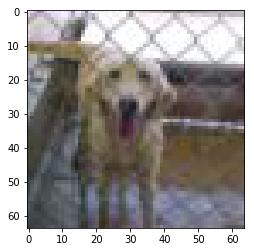

label    Cat
Name: 4, dtype: object
Proba cat: 0.7513642311096191, proba dog: 0.24863576889038086


In [42]:
missclassified = 3
imgplot = plt.imshow(submission[missclassified])
plt.show()
print(y.iloc[missclassified])
print('Proba cat: {}, proba dog: {}'.format(*prob[missclassified]))

We think it was missclassified because of the grid, and also because of the pose of the dog.

Below is an image that was correctly classified but the network was unsure about the final class :

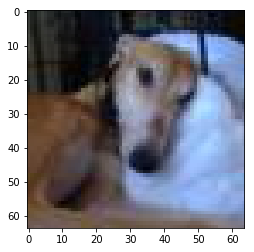

label    Dog
Name: 19, dtype: object
Proba cat: 0.4804835319519043, proba dog: 0.5195164084434509


In [40]:
hesitation = 18
imgplot = plt.imshow(submission[hesitation])
plt.show()
print(y.iloc[hesitation])
print('Proba cat: {}, proba dog: {}'.format(*prob[hesitation]))

The hesitation is most likely due to the pose of the dog.

Below we can find a few other interresting classifications.  
In the washing mashine, the network is very positive about the fact that the animal is a cat when we have trouble deciding.  
The black cat is well detected, because of the pose post probably.  
The greyscale image is classified as a dog, but the network is unsure.

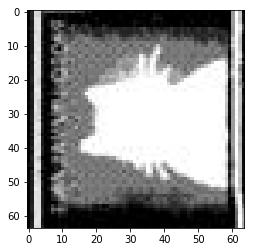

label    Dog
Name: 207, dtype: object
Proba cat: 0.48356953263282776, proba dog: 0.5164304971694946


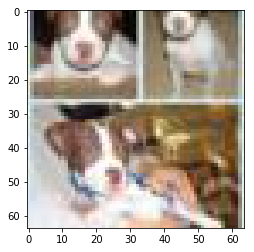

label    Cat
Name: 449, dtype: object
Proba cat: 0.5622230172157288, proba dog: 0.43777698278427124


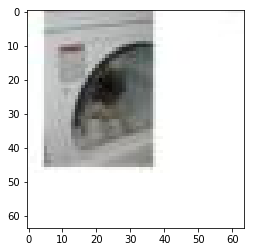

label    Cat
Name: 25, dtype: object
Proba cat: 0.7182638645172119, proba dog: 0.2817361652851105


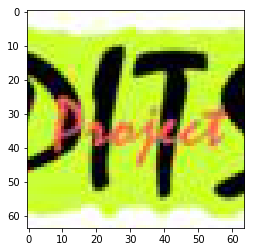

label    Dog
Name: 34, dtype: object
Proba cat: 0.3265236020088196, proba dog: 0.6734763979911804


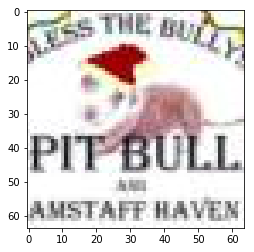

label    Dog
Name: 79, dtype: object
Proba cat: 0.2997668385505676, proba dog: 0.7002331018447876


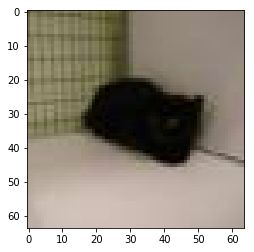

label    Cat
Name: 104, dtype: object
Proba cat: 0.9352701306343079, proba dog: 0.06472989171743393


In [45]:
other_list = [206, 448, 24, 33, 78, 103]
for other in other_list:
    imgplot = plt.imshow(submission[other])
    plt.show()
    print(y.iloc[other])
    print('Proba cat: {}, proba dog: {}'.format(*prob[other]))